In [1]:
import torch
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import time

In [5]:
# Provide your path to some feature vectors here
# You can obtain features like described here:
# https://github.com/lukemelas/deep-spectral-segmentation#step-1-feature-extraction
path = "/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/0002_resized.pth"

In [6]:
# Path for Eigen Vectors
# path = "/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64pred_dssubmax_10/0002_resized.pth"
# data = torch.load('/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64pred_dssubmax_10/0002_resized.pth')
# eigen_vectors = data['eigenvectors']

dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
3.91244970401749 seconds to compute eigenvectors with scipy.sparse.linalg.eigsh
0.12964422581717372 seconds to compute eigenvectors with torch.lobpcg
0.44623086089268327 seconds to compute eigenvectors with np.linalg.eigh
h,w= 32 32
(1024, 7)
(1024, 7)
(1024, 7)
(1024, 7)
(1024, 7)
(1024, 7)
torch.Size([1024, 7])
torch.Size([1024, 7])
torch.Size([1024, 7])
torch.Size([1024, 7])
torch.Size([1024, 7])
torch.Size([1024, 7])
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


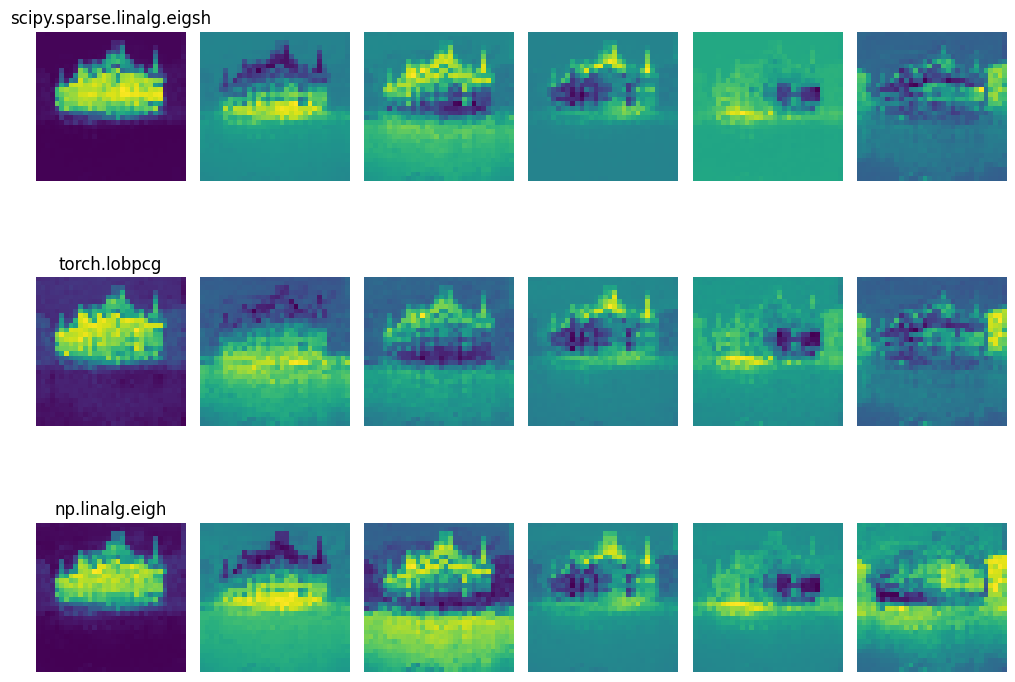

In [10]:

# Number of eigenvectors to compute plus 1 (zeroth eigenvector will be noise)
K = 6 + 1

f = torch.load(path)
print(f.keys())
_, _, h, w = f["shape"]
h = h // f["patch_size"]
w = w // f["patch_size"]
features = f["k"][0].cpu().numpy()
W = features @ features.T
W[W < 0] = 0

D = np.diag(W.sum(axis=1))

start_time = time.perf_counter()

# 0.18 seconds
eigenvalues1, eigenvectors1 = scipy.sparse.linalg.eigsh(D - W, k=K, sigma=0, which='LM', M=D)

elapsed_time = time.perf_counter() - start_time

print(elapsed_time, "seconds to compute eigenvectors with scipy.sparse.linalg.eigsh")

# Normalize rows
W /= W.sum(axis=1, keepdims=True)
D = np.diag(W.sum(axis=1))

start_time = time.perf_counter()

# 0.24 seconds, but can change iterations to make it go slower or even faster
eigenvalues2, eigenvectors2 = torch.lobpcg(torch.from_numpy(D - W), k=K, largest=False, niter=30)

elapsed_time = time.perf_counter() - start_time

print(elapsed_time, "seconds to compute eigenvectors with torch.lobpcg")

start_time = time.perf_counter()

# 3 seconds
eigenvalues3, eigenvectors3 = np.linalg.eigh(D - W)

elapsed_time = time.perf_counter() - start_time

print(elapsed_time, "seconds to compute eigenvectors with np.linalg.eigh")
print("h,w=", h,w)
plt.figure(figsize=(10, 8))
for j, (title, eigenvectors) in enumerate([
    ("scipy.sparse.linalg.eigsh", eigenvectors1),
    ("torch.lobpcg", eigenvectors2),
    ("np.linalg.eigh", eigenvectors3),
]):
    for i in range(1, K):
        print(eigenvectors.shape)
        plt.subplot(3, K - 1, i + j * (K - 1))
        if i == 1: plt.title(title)

        image = eigenvectors[:, i].reshape(h, w)

        # Make image positive because it looks nicer
        if image.mean() < 0: image = -image

        plt.imshow(image)
        plt.axis('off')
plt.tight_layout()
plt.show()